In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [3]:
sms = pd.read_csv('spam.csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

In [5]:
sms.groupby('label').describe().stack()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

Text(0.5, 1.0, 'target distribution')

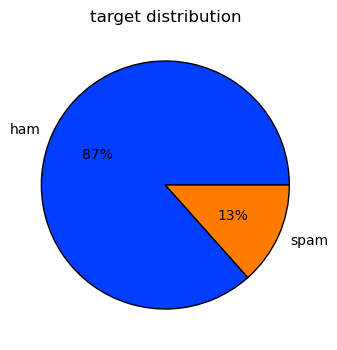

In [50]:
label_ind = sms.groupby('label')['label'].count().index
lable_val = sms.groupby('label')['label'].count().values

palette_color = sns.color_palette('bright')
plt.figure(figsize=(4,6))
plt.pie(lable_val,labels=label_ind,
        colors=palette_color, autopct='%.0f%%')
plt.title('target distribution')

because we face unbalance dataset it needs to add other values to verify the useful algorithm for this dataset,
- typeII error count
- F1 score value

In [6]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

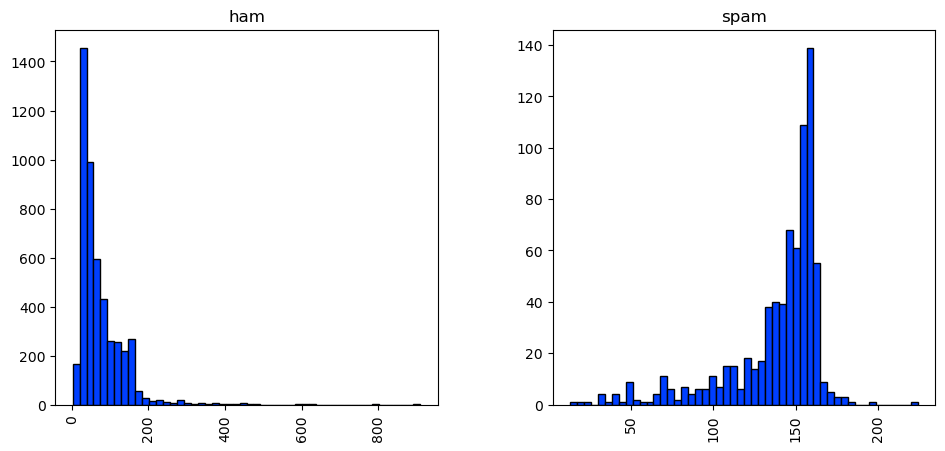

In [7]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

In [54]:
text_feat = sms['message'].copy()

In [55]:
# removing common english words from each sentence
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [56]:
text_feat = text_feat.apply(text_process)

In [57]:
vectorizer = TfidfVectorizer()

In [58]:
features = vectorizer.fit_transform(text_feat)

In [59]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], 
                                                                            test_size=0.3, random_state=111)

In [60]:
# traditional machine learning algorithms
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [61]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

In [62]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

In [63]:
def predict_labels(clf, features):
    return (clf.predict(features))

In [91]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred),f1_score(labels_test,pred, average="binary", pos_label="ham")
                           ,confusion_matrix(labels_test,pred)[1][0]]))

D:\Anaconda\Documents\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [92]:
df = pd.DataFrame.from_dict(dict(pred_scores),orient='index', columns=['accuracy','f1_score','typeII'])
df

,accuracy,f1_score,typeII
SVC,0.978469,0.987629,33
KN,0.924641,0.958056,125
NB,0.984450,0.990978,14
DT,0.958732,0.976100,38
LR,0.943182,0.967742,80
RF,0.970096,0.982935,50
AdaBoost,0.967105,0.981132,45
BgC,0.966507,0.980690,38
ETC,0.977273,0.986968,37


The evaluation does based on maximum of f1_score when typeII error value is lesser than 30, so in the first find the best algorithm the 'MultinomialNB(alpha=0.2)' is selected

In [95]:
df_accuracy = df['accuracy']

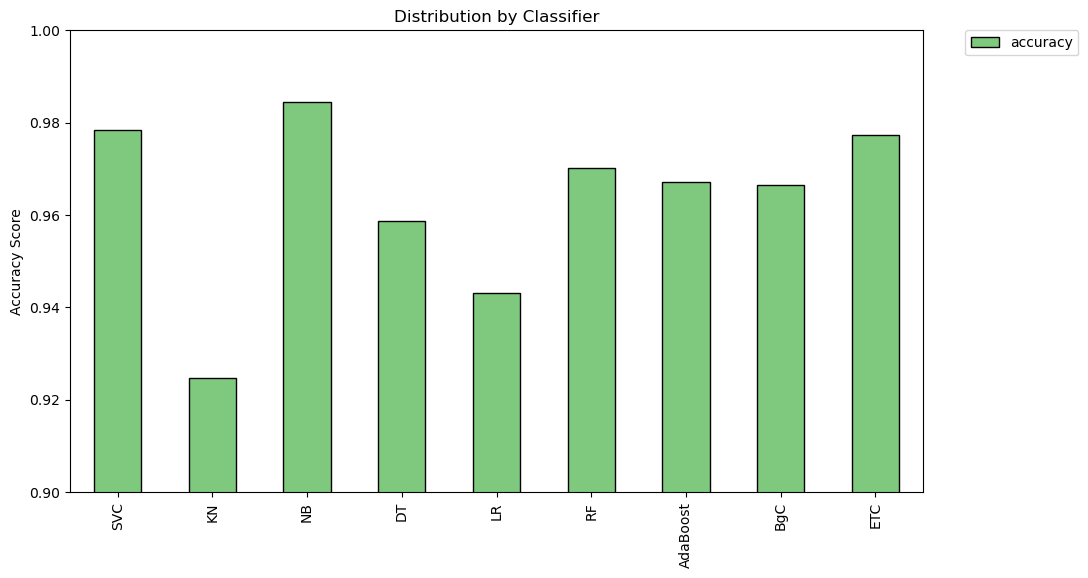

In [96]:
df_accuracy.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [97]:
# change words to root form and make words lower-case 
# https://www.datasciencelearner.com/how-to-use-snowball-stemmer-nltk-package/
# https://towardsdatascience.com/stemming-corpus-with-nltk-7a6a6d02d3e5
def stemmer(text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

In [98]:
text_feat = text_feat.apply(stemmer)

In [99]:
# tekonizer after using standardize words with SnowballStemmer
features = vectorizer.fit_transform(text_feat)

In [100]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'],
                                                                            test_size=0.3, random_state=111)

In [101]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred),f1_score(labels_test,pred, average="binary", pos_label="ham")
                           ,confusion_matrix(labels_test,pred)[1][0]]))

D:\Anaconda\Documents\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [102]:
df2 = pd.DataFrame.from_dict(dict(pred_scores),orient='index', columns=['accuracy2','f1_score','typeII'])
df2

,accuracy2,f1_score,typeII
SVC,0.978469,0.987620,32
KN,0.927632,0.959626,119
NB,0.985048,0.991328,14
DT,0.959928,0.976760,35
LR,0.946770,0.969718,74
RF,0.974880,0.985626,42
AdaBoost,0.970096,0.982747,34
BgC,0.968900,0.982032,33
ETC,0.977871,0.987290,34


'MultinomialNB(alpha=0.2)' is selected in this situation as well

In [103]:
df2_accuracy = df2['accuracy2']
df_accuracy = pd.concat([df_accuracy,df2_accuracy],axis=1)

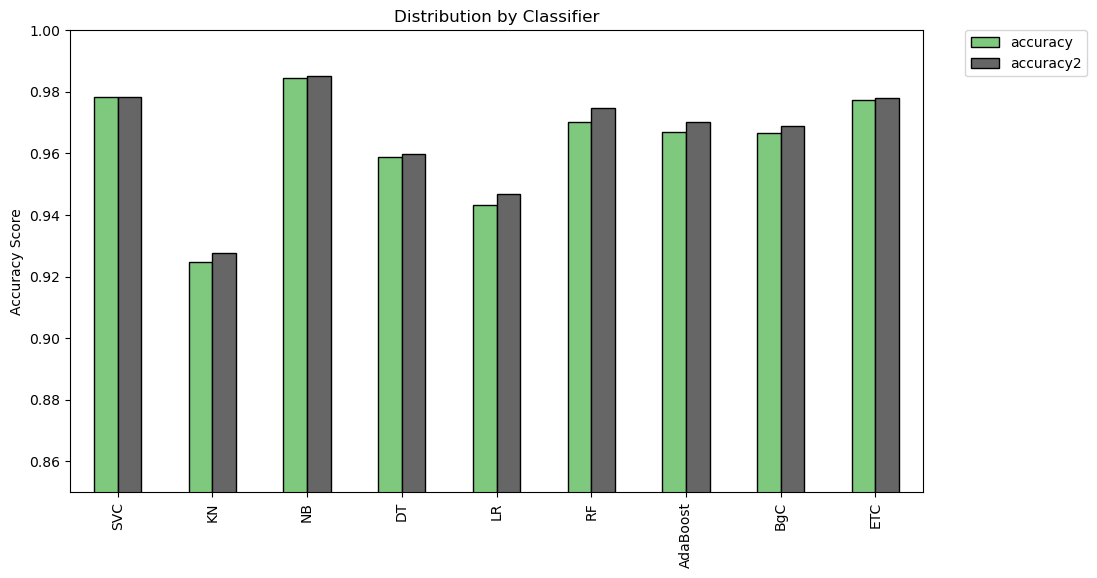

In [104]:
df_accuracy.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [105]:
# predict based on length of messages
lf = sms['length'].values
newfeat = np.hstack((features.todense(),lf[:, None])) # just give it to algorithm to learn

In [106]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat, sms['label'], 
                                                                            test_size=0.3, random_state=111)

In [107]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred),f1_score(labels_test,pred, average="binary", pos_label="ham")
                           ,confusion_matrix(labels_test,pred)[1][0]]))

D:\Anaconda\Documents\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\skl

In [108]:
df3 = pd.DataFrame.from_dict(dict(pred_scores),orient='index', columns=['accuracy3','f1_score','typeII'])
df3

,accuracy3,f1_score,typeII
SVC,0.861244,0.925450,232
KN,0.882775,0.931850,96
NB,0.982656,0.989983,22
DT,0.957536,0.975339,35
LR,0.954545,0.974114,66
RF,0.975478,0.985954,40
AdaBoost,0.961722,0.977885,39
BgC,0.966507,0.980623,33
ETC,0.975478,0.985906,35


'MultinomialNB(alpha=0.2)' is selected in this situation as well

In [109]:
df3_accuracy = df3['accuracy3']
df_accuracy = pd.concat([df_accuracy,df3_accuracy],axis=1)

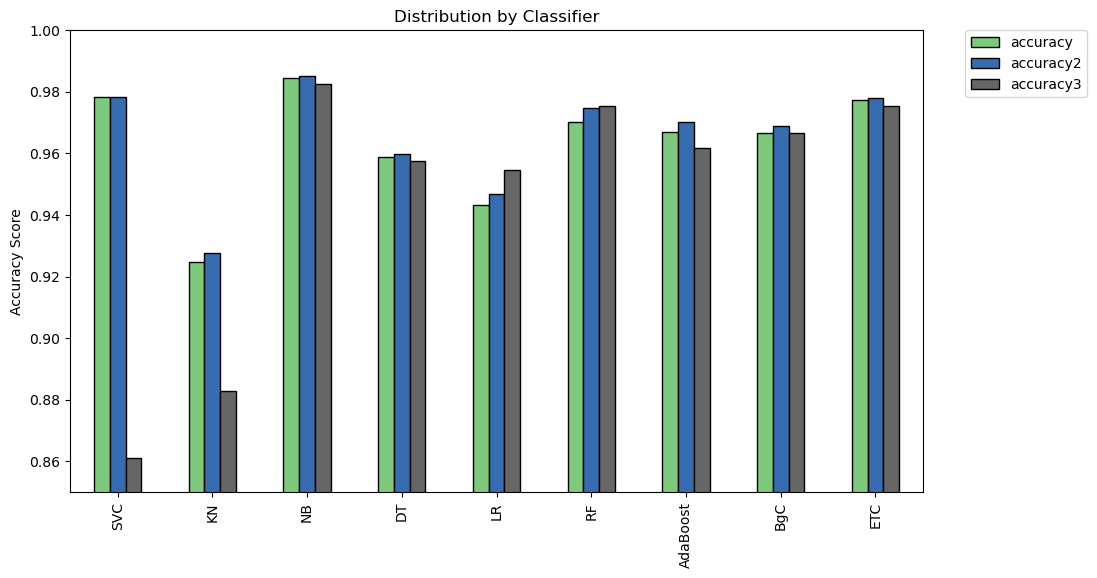

In [110]:
df_accuracy.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [88]:
from sklearn.ensemble import VotingClassifier

In [89]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [90]:
eclf.fit(features_train,labels_train)

D:\Anaconda\Documents\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\skl

VotingClassifier(estimators=[('BgC',
                              BaggingClassifier(n_estimators=9,
                                                random_state=111)),
                             ('ETC',
                              ExtraTreesClassifier(n_estimators=9,
                                                   random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=31,
                                                     random_state=111)),
                             ('Ada',
                              AdaBoostClassifier(n_estimators=62,
                                                 random_state=111))],
                 voting='soft')

In [91]:
pred = eclf.predict(features_test)

D:\Anaconda\Documents\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda\Documents\lib\site-packages\skl

In [92]:
print(accuracy_score(labels_test,pred))

0.9772727272727273
